# Readability Exercise

Welcome! Below you will implement two metrics for evaluating the readability of documents:

1. Flesch–Kincaid readability Grade Index 
2. Gunning Fog Index

The solutions are in [readability_solutions.py](./readability_solutions.py). You can also click the jupyter icon to see all the files in the folder.

To load all the functions in the solutions, simply include `from solutions import *`

## 0. Initialization

Let's read-in our text files. We have three different texts files to play with: 

1. `physics.txt`: taken from a technical wikipedia article about a theoretical physics idea called [Supersymmetry](https://en.wikipedia.org/wiki/Supersymmetry)

2. `APPL_10k_2017.txt`: the 2017 10-K Item IA for APPLE INC, taken from the EDGAR website

3. `alice.txt`: Excerpts from "Alice in Wonderland", the novel is in the public domain and freely available

In [1]:
# download some excerpts from 10-K files

from download10k import get_files

CIK = {'ebay': '0001065088', 'apple':'0000320193', 'sears': '0001310067'}
get_files(CIK['ebay'], 'EBAY')
get_files(CIK['apple'], 'AAPL')
get_files(CIK['sears'], 'SHLDQ')


downloading 10-Ks item 1A for CIK = 0001065088 ...
skipping EBAY_10k_2017.txt
skipping EBAY_10k_2016.txt
skipping EBAY_10k_2015.txt
skipping EBAY_10k_2014.txt
skipping EBAY_10k_2013.txt
downloading 10-Ks item 1A for CIK = 0000320193 ...
skipping AAPL_10k_2017.txt
skipping AAPL_10k_2016.txt
skipping AAPL_10k_2015.txt
skipping AAPL_10k_2014.txt
skipping AAPL_10k_2013.txt
downloading 10-Ks item 1A for CIK = 0001310067 ...
skipping SHLDQ_10k_2017.txt
skipping SHLDQ_10k_2016.txt
skipping SHLDQ_10k_2015.txt
skipping SHLDQ_10k_2014.txt
skipping SHLDQ_10k_2013.txt


In [2]:
# sentences separated by ; are better viewed as multiple sentences
# join combines all the newlines in the file

f = open("physics.txt", "r")
text_phy=''.join(f).replace(';','.')

f = open("alice.txt", "r")
text_alice=''.join(f).replace(';','.')

f = open("AAPL_10k_2017.txt", "r")
text_10k=''.join(f).replace(';','.')



In [3]:
# check out some of the texts
print(text_10k[:500]+"...\n")
print(text_phy[:500]+"...\n")
print(text_alice[:500]+"...\n")

The following discussion of risk factors contains forward-looking statements. These risk factors may be important to understanding other statements in this Form 10-K. The following information should be read in conjunction with Part II, Item 7, “Management’s Discussion and Analysis of Financial Condition and Results of Operations” and the consolidated financial statements and related notes in Part II, Item 8, “Financial Statements and Supplementary Data” of this Form 10-K. The business, financia...

In particle physics, supersymmetry (SUSY) is a principle that proposes a relationship between two basic classes of elementary particles: bosons, which have an integer-valued spin, and fermions, which have a half-integer spin. A type of spacetime symmetry, supersymmetry is a possible candidate for undiscovered particle physics, and seen as an elegant solution to many current problems in particle physics if confirmed correct, which could resolve various areas where current theories are believ

## 1. Pre-processing
Here, we need to define functions that can split our texts into sentences, and split our sentences into words

In [4]:
# tokenize and clean the text
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import Counter
from nltk.corpus import stopwords

from nltk import word_tokenize
from syllable_count import syllable_count


nltk.download('wordnet')

sno = SnowballStemmer('english')
wnl = WordNetLemmatizer()

from nltk.tokenize import RegexpTokenizer

# tokenizer that selects out non letter and non symbol (i.e. all alphabets)
word_tokenizer = RegexpTokenizer(r'[^\d\W]+')


def word_tokenize(sent):
    return [ w for w in word_tokenizer.tokenize(sent) if w.isalpha() ]

# for the sentence tokenizer
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# you can tokenize sentences by calling
# sent_tokenize(document)

# and tokenize words by calling
# word_tokenize(sentence)

# syllable_count counts the number of syllables in a word
# it's included in syllable_count.py

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now implement three functions

1. `sentence_count`: a simple function that returns the number of sentences in a document

2. `word_count`: a simple function that returns the number of words in a sentence

3. `hard_word_count`: a simple function that returns the number of words with more than 3 syllables, while removing suffixes like "-ed", and "-ing". This can be done by lemmatizing the word, i.e. `wnl.lemmatize(word, pos='v')`

the function `word_tokenize(sentence)` will be useful here

In [5]:
from syllable_count import syllable_count

def sentence_count(text):
    sentences = [sent for sent in sent_tokenize(text)]
    return len(sentences)

def word_count(sent):
    words = [ w for w in word_tokenizer.tokenize(sent)]
    return len(words)

def hard_word_count(sent):
    wnl = WordNetLemmatizer()
    hard_words = [w for w in word_tokenizer.tokenize(sent) if syllable_count(wnl.lemmatize(w, pos='v')) >= 3]
    return len(hard_words)

## 2. Readability Grade-Levels

Here, you will implement the two readability indices (grade levels). They are defined by

\begin{align}
\textrm{Flesch–Kincaid Grade} 
= 0.39 \left(
\frac{\textrm{Number of words}}{\textrm{Number of sentences}}
\right) \\
+11.8
\left(
\frac{\textrm{Number of syllables}}{\textrm{Number of words}}
\right)
-15.59
\end{align}

and

\begin{align}
\textrm{Gunning-Fog Grade} 
=\; &0.4 \bigg[ 
\left(
\frac{\textrm{Number of words}}{\textrm{Number of sentences}}
\right) 
+100
\left(
\frac{\textrm{Number of hard words}}{\textrm{Number of words}}
\right)
\bigg]
\end{align}

To count syllables, we've added a syllable_count function you can access via 

```
from syllable_count import syllable_count
syllable_count("syllable")
```

Below, implement the function `flesch_index` and `fog_index` that computes the readability grade level for a given text.

In [6]:
import numpy as np
def flesch_index(text):
    sentences = sent_tokenize(text)

    total_sentences = len(sentences)
    total_words = np.sum([ word_count(s) for s in sentences ])
    total_syllables = np.sum([ np.sum([ syllable_count(w) for w in word_tokenize(s) ]) \
                              for s in sentences ])
    
    return 0.39*(total_words/total_sentences) + \
            11.8*(total_syllables/total_words) - 15.59

def fog_index(text):
    sentences = sent_tokenize(text)

    total_sentences = len(sentences)
    total_words = np.sum([ word_count(s) for s in sentences ])
    total_hard_words = np.sum([ hard_word_count(s) for s in sentences ])
    
    return 0.4*((total_words/total_sentences) + \
            100.0*(total_hard_words/total_words))

## 3 Results

Now that you've coded up the exercises, compute the grade levels for each of the texts given.


In [7]:
# to test the solutions
# uncommon next line
# from readability_solutions import *

print(flesch_index(text_alice),fog_index(text_alice))
print(flesch_index(text_phy),fog_index(text_phy))
print(flesch_index(text_10k),fog_index(text_10k))

7.78094652406 9.73654188948
16.3171712123 19.3225332001
18.2108288106 21.5614490682


You should expect a grade level around 7-10 for `alice.txt`, and around 16-19 for `physics.txt`, and 18+ for financial documents! 

It turns out 10-Ks are really *hard* to read legal documents!
Now, let's compute the readability for all the 10-Ks we have

In [8]:
filelist_10k=!ls *10k*txt


flesch = []
fog = []

for file in filelist_10k:
    with open(file, 'r') as f:
        text=''.join(f).replace(';','.')
        flesch.append(flesch_index(text))
        fog.append(fog_index(text))
        print(file, flesch[-1],fog[-1])

AAPL_10k_2013.txt 18.1336596757 21.4219541786
AAPL_10k_2014.txt 18.1536894665 21.533048686
AAPL_10k_2015.txt 18.2144706379 21.6060051245
AAPL_10k_2016.txt 18.2620196893 21.6361424013
AAPL_10k_2017.txt 18.2108288106 21.5614490682
EBAY_10k_2013.txt 17.2088261149 19.4673717189
EBAY_10k_2014.txt 17.522305957 19.844332095
EBAY_10k_2015.txt 17.1741438469 19.5172704435
EBAY_10k_2016.txt 16.8119978036 19.2121925858
EBAY_10k_2017.txt 16.988036714 19.3980211714
SHLDQ_10k_2013.txt 16.8126305116 19.2154420317
SHLDQ_10k_2014.txt 17.1138126995 19.5253765922
SHLDQ_10k_2015.txt 18.304118527 21.0016011567
SHLDQ_10k_2016.txt 18.7321020854 21.4781606764
SHLDQ_10k_2017.txt 17.755571973 20.6452057848


Superficially, and according to our readability metrics, reading 10-Ks is harder than reading articles on theoretical physics!

# Bonus exercise:
How are the two readability grade-levels correlated? Compute the covariance matrix of the two readability indices we have on all the 10K documents, and make a scatter plot of Flesch index vs Fog index. Also perform a least-squared fit to the result and plot it as well.

(change bottom cell to code and remove html tags for solution)

[[ 0.40312929  0.62255504]
 [ 0.62255504  1.05067737]]


Text(0,0.5,'Fog Index')

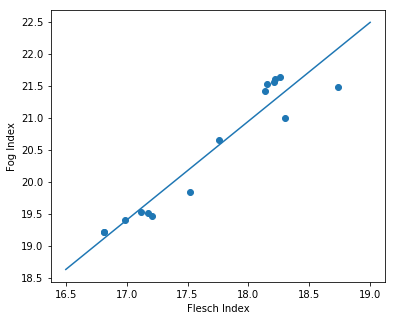

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


# TO DO
cov = np.cov(flesch,fog) 
print(cov)

%matplotlib inline

plt.figure(figsize=(6,5)) 
plt.scatter(flesch,fog)

slope, intercept, r_value, p_value, std_err = linregress(flesch, fog)

x=np.linspace(16.5,19,101) 
y=slope*x+intercept
plt.plot(x,y)

plt.xlabel("Flesch Index")
plt.ylabel("Fog Index")

<font color="white">

#solution
cov = np.cov(flesch,fog)
print(cov)

%matplotlib inline

plt.figure(figsize=(6,5))
plt.scatter(flesch,fog) 

slope, intercept, r_value, p_value, std_err = linregress(flesch, fog)

x=np.linspace(16.5,19,101)
y=slope*x+intercept
plt.plot(x,y)

plt.xlabel("Flesch Index")
plt.ylabel("Fog Index")

</font>